In [17]:
import sys
sys.path.append("C://Users//User//PycharmProjects//Musgrave_scripts//BenRich//common_funcs")
import cohpfuncs as cfunc
import jdftxfuncs as jfunc
data_dir = "E://perl//pscratch//beri9208//pot_scan//PtPyrOpt150//"
#data_dir = "D://scratch_backup//perl//pot_scan//AuPyrOpt//"
data_label = data_dir.split("//")[-2]
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from numba import jit
savedir = "C://Users//User//Desktop//Band_energy_trends//"
data_prefix = "output."

surf_labels = ["2n-cis", "2n-cis"]
def app_dir(surf_idx, mu_idx):
    """
    :param surf_idx: 0 --> 2n-cis, 1 --> 2n-trans
    :param mu_idx: 0 --> No_bias, -1 --> dneg/1, 1 --> 2pos/1
    :return:
    """
    out_str = surf_labels[surf_idx] + "//"
    if mu_idx == 0:
        out_str += "No_bias//"
    else:
        if mu_idx > 0:
            out_str += "dpos//"
        else:
            out_str += "dneg//"
        out_str += str(int(abs(mu_idx))) + "//"
    return data_dir + out_str
bias_labels = ["-0.3V", "0.0V", "0.3V", "0.6", "0.9V", "1.2V", "1.5V", "1.8V", "-2.4V", "-2.1V", "-1.8V", "-1.5V", "-1.2V", "-0.9V", "-0.6V"]
bidrange = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
idx_pzc = bidrange.index(0)
bshift = int(np.floor(len(bidrange)/2.))
nbids = len(bidrange)
ncalcs = nbids*2

def gen_dirname(surf_idx, bias_idx):
    slabel = surf_labels[surf_idx]
    out_str = save_dir + slabel + str(bias_idx)
    out_str += '//'
    return out_str

def gen_savedirname(surf_idx, savedir):
    slabel = surf_labels[surf_idx]
    out_str = savedir + slabel
    out_str += '//'
    return out_str

def setupdir(dirname):
    try:
        os.mkdir(dirname)
    except:
        None
setupdir(savedir)


def gen_savename(surf_idx, j):
    out_str = str(j) + "_" +  surf_labels[surf_idx]
    return out_str

def gen_title(surf_idx, j):
    out_str = str(j) + " " +  surf_labels[surf_idx]
    return out_str

@jit(nopython=True)
def get_band_vector_nosmear_helper(ejk, height, Erange, outij, dE):
    a = ejk - min(Erange)
    b = a / dE
    idx = int(np.floor(b))
    spill = abs(b-idx)
    outij[idx] += height*(1 - spill)
    outij[idx+1] += height*spill

@jit(nopython=True)
def get_band_vector_stats(E, wk, nk, nj, out):
    for ij in range(nj):
        Es = np.zeros(nk)
        weights = np.zeros(nk)
        for ik in range(nk):
            ejk = E[ik][ij]
            height = wk[ik]
            Es[ik] = ejk
            weights[ik] = height
        weighted_mean = np.average(Es, weights=weights)
        weighted_std = np.sqrt(np.average((Es - weighted_mean) ** 2, weights=weights))
        out[ij][0] += weighted_mean
        out[ij][1] += weighted_std
    return out


@jit(nopython=True)
def get_plot_stuff(sidx, bidx, j, ndatum):
    dlook = ndatum[sidx][bidx]
    y = np.real(dlook[j])
    return y

def system_bandwise_stats(surf_idx, bias_idx):
    try:
        proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
                app_dir(surf_idx, bias_idx) + data_prefix + "bandProjections",
                app_dir(surf_idx, bias_idx) + data_prefix + "Gvectors",
                app_dir(surf_idx, bias_idx) + data_prefix + "eigenvals")
    except:
        proj, nStates, nBands, nProj, nOrbsPerAtom, wk, k_points, E = cfunc.parse_data(
                app_dir(surf_idx, bias_idx) + "bandProjections",
                app_dir(surf_idx, bias_idx) + "Gvectors",
                app_dir(surf_idx, bias_idx) + "eigenvals")
    try:
        S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + data_prefix + "out")
    except:
        S, R, mu = jfunc.get_vars(app_dir(surf_idx, bias_idx) + "out")
    nk, nj = np.shape(E)
    print(nk)
    print(nj)
    out = np.zeros([nj, 2])
    band_vec = get_band_vector_stats(E, wk, nk, nj, out)
    """
    pcoops_list: 2d list
    Erange: 1d range
    titles_and_idcs_and_mu: [title, data i/j pair, mu]
    """
    return band_vec, mu

In [18]:
datum = []
for sidx in range(len(surf_labels)):
    datum.append([])
    for bidx in range(len(bias_labels)):
        start = time.time()
        datum[-1].append(system_bandwise_stats(sidx, bidx - bshift))
        end = time.time()
        elapsed = end - start
        print(str(sidx*len(bias_labels) + bidx + 1) + "/" + str(len(surf_labels)*len(bias_labels)) + ": " + f'{elapsed:.{4}g}' )

18
150


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'wk' of function 'get_band_vector_stats'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_5892\2525489649.py", line 77:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


1/30: 1.905
18
150
2/30: 1.432
18
150
3/30: 1.331
18
150
4/30: 1.318
18
150
5/30: 1.31
18
150
6/30: 1.306
18
150
7/30: 1.356
18
150
8/30: 1.42
18
150
9/30: 1.388
18
150
10/30: 1.381
18
150
11/30: 1.309
18
150
12/30: 1.314
18
150
13/30: 1.324
18
150
14/30: 1.3
18
150
15/30: 1.302
18
150
16/30: 1.309
18
150
17/30: 1.283
18
150
18/30: 1.3
18
150
19/30: 1.282
18
150
20/30: 1.288
18
150
21/30: 1.289
18
150
22/30: 1.29
18
150
23/30: 1.268
18
150
24/30: 1.267
18
150
25/30: 1.281
18
150
26/30: 1.266
18
150
27/30: 1.268
18
150
28/30: 1.24
18
150
29/30: 1.281
18
150
30/30: 1.319


In [19]:
mus = np.zeros([len(surf_labels), len(bidrange)])
for sidx in range(len(surf_labels)):
    for bidx in range(len(bias_labels)):
        mus[sidx][bidx] += datum[sidx][bidx][1]
mu_pzcs = np.zeros(len(surf_labels))
for sidx in range(len(surf_labels)):
    mu_pzcs[sidx] = mus[sidx][idx_pzc]
nj = len(datum[1][0][0])
ndatum = np.zeros([np.shape(datum)[0], len(bidrange), nj, 2])
for sidx in range(len(surf_labels)):
    for bidx in range(len(bidrange)):
        for j in range(nj):
            ndatum[sidx, bidx, j] += np.real(datum[sidx][bidx][0][j])

C:\Users\User\anaconda3\envs\Musgrave_scripts\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [20]:
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
ys = np.zeros([len(surf_labels), nj, len(bias_labels)])
e_pzcs = np.zeros([len(surf_labels), nj])
for sidx in range(len(surf_labels)):
    for jidx in range(nj):
        e_pzc = ndatum[sidx,idx_pzc,jidx,0]
        y = ndatum[sidx,:,jidx,0] - e_pzc
        ys[sidx, jidx] += y
        e_pzcs[sidx, jidx] += e_pzc
vbounds = np.zeros([len(surf_labels), 2])
for sidx in range(len(surf_labels)):
    vbounds[sidx][0] = np.min(e_pzcs[sidx])
    vbounds[sidx][1] = np.max(e_pzcs[sidx])
norms = []
for sidx in range(len(surf_labels)):
    norms.append(colors.Normalize(vmin = vbounds[sidx][0], vmax = vbounds[sidx][1]))
color_maps = []
user_cmap = 'jet'
cmap = plt.cm.get_cmap(user_cmap, lut=256)
for sidx in range(len(surf_labels)):
    color_maps.append([cmap(norms[sidx](w)) for w in e_pzcs[sidx]])

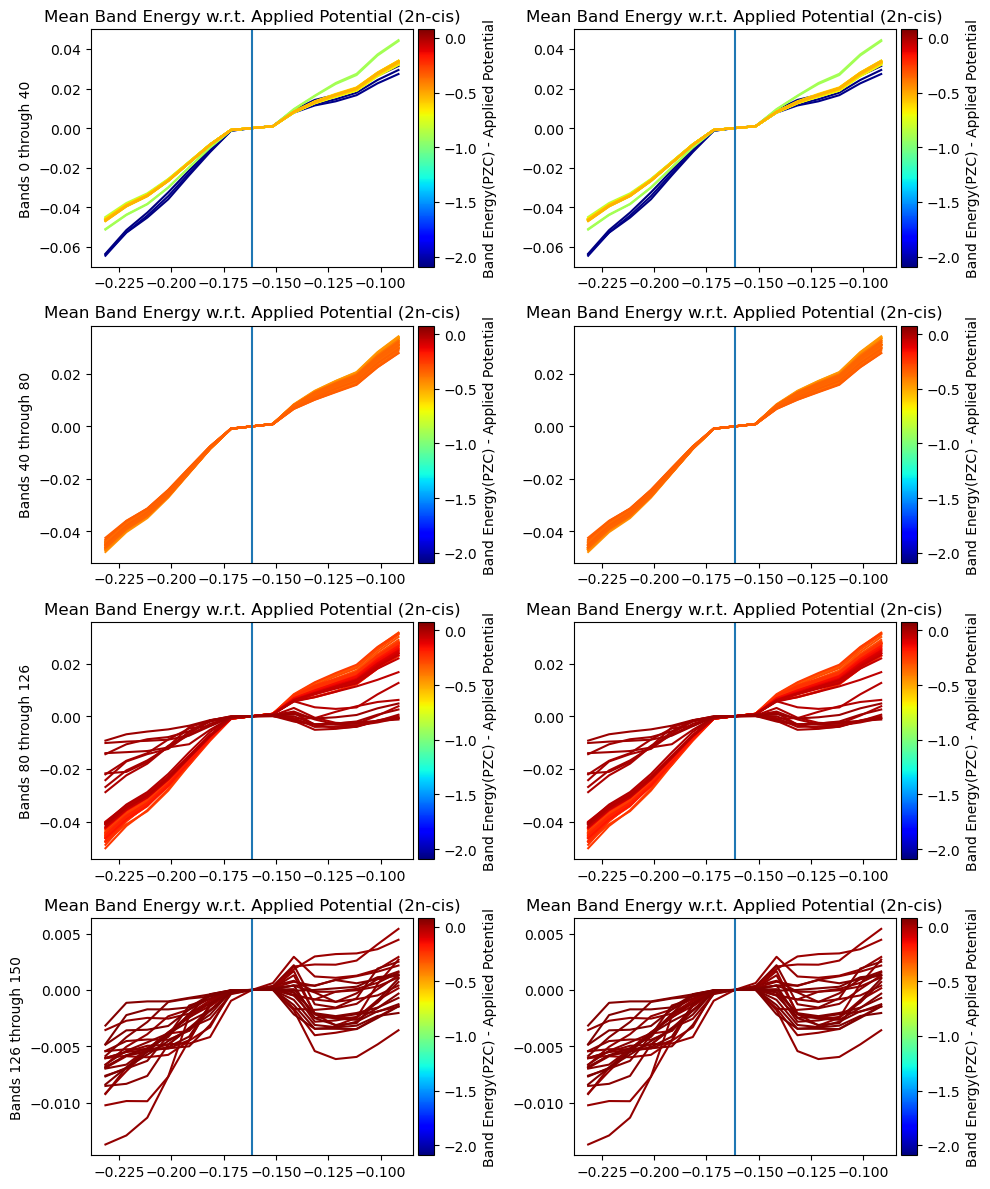

In [21]:
seg_pts = [0, 40, 80, 126, nj]
fig, ax = plt.subplots(nrows=len(seg_pts) - 1, ncols=len(surf_labels), figsize=(5*len(surf_labels), 12))
plt.title('Mean Band Energy w.r.t. Applied Potential')
for sidx in range(len(surf_labels)):
    for segx in range(len(seg_pts) - 1):
        start = seg_pts[segx]
        stop = seg_pts[segx + 1]
        for jidx in range(start, stop):
            e_pzc = ndatum[sidx, idx_pzc, jidx, 0]
            x = mus[sidx]
            y = ndatum[sidx, :, jidx, 0] - e_pzc
            ax[segx][sidx].plot(x, y, color=color_maps[sidx][jidx])
        divider = make_axes_locatable(ax[segx][sidx])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = fig.colorbar(cm.ScalarMappable(norm=norms[sidx], cmap=user_cmap), cax=cax)
        cb.set_label('Band Energy(PZC) - Applied Potential')
        ax[segx][sidx].set_title('Mean Band Energy w.r.t. Applied Potential (' + surf_labels[sidx] + ')')
        ax[segx][sidx].axvline(x=mu_pzcs[sidx])
for segx in range(len(seg_pts) - 1):
    ax[segx][0].set_ylabel('Bands ' + str(seg_pts[segx]) + ' through ' + str(seg_pts[segx + 1]))
plt.tight_layout()
plt.savefig(savedir + data_label + '.png')

[[-0.050131   -0.060131   -0.070131   -0.080131   -0.090131   -0.100131
  -0.110131   -0.12012664 -0.130131   -0.140131   -0.150131   -0.160131
  -0.170131   -0.180131   -0.190131  ]
 [-0.050131   -0.060131   -0.070131   -0.080131   -0.090131   -0.100131
  -0.110131   -0.12012664 -0.130131   -0.140131   -0.150131   -0.160131
  -0.170131   -0.180131   -0.190131  ]]


In [56]:
stdev_bounds = np.zeros([len(surf_labels), 2])
for sidx in range(len(surf_labels)):
    ymin = 100
    ymax = -100
    for jidx in range(nj):
        ymin = min(ymin, np.min(ndatum[sidx, :, jidx, 1]))
        ymax = max(ymax, np.max(ndatum[sidx, :, jidx, 1]))
    stdev_bounds[sidx][0] += ymin
    stdev_bounds[sidx][1] += ymax

In [57]:
def plot_bias_corr(sidx, jidx, savedir):
    fig, ax1 = plt.subplots()
    ax1.plot(mus[sidx,:], ndatum[sidx,:,jidx,0], color='C0', label = 'mean')
    ax2 = ax1.twinx()
    ax2.plot(mus[sidx,:], ndatum[sidx,:,jidx,1], color='C1', label = 'st dev')
    ax1.set_title('Band ' + str(jidx))
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    yb = stdev_bounds[sidx]
    ax2.set_ylim(yb[0], yb[1])
    ax2.axvline(x=mu_pzcs[sidx], color='red')
    plt.savefig(gen_savedirname(sidx, savedir) + gen_savename(sidx, jidx) + '.png')
    plt.clf()
    fig.clf()

In [ ]:
for sidx in range(len(surf_labels)):
    setupdir(gen_savedirname(sidx, savedir))
    for jidx in range(nj):
        plot_bias_corr(sidx, jidx, savedir)